# OAK - logo generation
 - doc: https://github.com/openaiknowledge/pr3
 - Based on DCGAN: https://www.tensorflow.org/tutorials/generative/dcgan
 - Finally this strategy is not used to generate logo

 

# Import Libraries

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.utils 
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy as np

from google.colab import drive

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds

import pathlib

import time

# Load Dataset

In [ ]:
BASE_FOLDER = '/content/drive/My Drive/openaiknowledge/pr3/'
DATA = BASE_FOLDER + 'data/1/' #version 1
IMAGES = DATA + "images/"
MODEL = BASE_FOLDER + "model/1/"
IMAGES_OUT_TRAINING = IMAGES + "out_training/"
IMAGES_GENERATED = IMAGES + "generated/"

In [ ]:
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plot_image(image):
  plt.imshow(image, cmap="binary")
  plt.axis("off")

def show_image_pil(image_url):
  image = PIL.Image.open(image_url)
  plot_image(image)

def show_image(image_url):
  image = tf.keras.preprocessing.image.load_img(image_url)
  plot_image(image)

## Preprocessing data


In [ ]:
batch_size = 32
img_height = 256 #56 #todo review
img_width = img_height

In [ ]:
def normalize_image(image):
  return (image - 127.5) / 127.5

def desnormalize_image(image):
  return (image * 127.5) + 127.5

def rgb2gray(rgb):
    #return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    value =  tf.image.rgb_to_grayscale(rgb, name=None)
    return tf.reshape(value, list(rgb.shape)[0:2]) #plt needs gray in 2 dimensions

In [ ]:
train_logos_path = IMAGES + "logos"
train_ds_logos = tf.keras.preprocessing.image_dataset_from_directory(
  train_logos_path,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  smart_resize="True")
print(train_ds_logos.class_names)

Found 77 files belonging to 1 classes.
Using 62 files for training.
['sensodyne']


In [ ]:
train_2011_path = IMAGES + "space" #'/content/drive/My Drive/openaiknowledge/pr3/data/1/images/2001'
train_ds_2001 = tf.keras.preprocessing.image_dataset_from_directory(
  train_2011_path,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  smart_resize="True")

#train_images_2001 = train_images.reshape(train_images.shape[0], img_height, img_width, 1).astype('float32')
#train_images_2001 = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

print(train_ds_2001.class_names)


Found 5 files belonging to 1 classes.
Using 4 files for training.
['hal']


In [ ]:
print(type(train_ds_2001))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


(-0.5, 255.5, 255.5, -0.5)

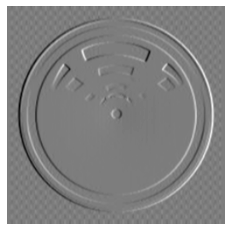

In [ ]:
for images, labels in train_ds_2001.take(1):
  hal = images[0]
hal
plt.imshow(hal.numpy().astype("uint8"))
plt.axis("off")

total_elements = 1000
train_ds_2001_images = np.empty(shape=(total_elements,img_height,img_width,3))
for i in range(total_elements):
  train_ds_2001_images[i] = hal

train_ds_2001_images = normalize_image(train_ds_2001_images)
#train_ds_2001_images_tf = tf.convert_to_tensor(train_ds_2001_images)

train_ds_2001_images_tf = tf.data.Dataset.from_tensor_slices(train_ds_2001_images)
train_ds_2001_images_tf_batch = train_ds_2001_images_tf.batch(10)
element = desnormalize_image(train_ds_2001_images[total_elements-1])
element = rgb2gray(element.astype("uint8"))
plt.imshow(element, cmap="gray")
plt.axis("off")

### Visualize the data

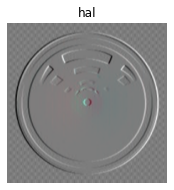

In [ ]:
import matplotlib.pyplot as plt

def show_ds_example(ds):
  plt.figure(figsize=(10, 10))
  for images, labels in ds.take(1):
  #for images in ds.take(1):
    for i in range(1):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(ds.class_names[labels[i]])
      plt.axis("off")

show_ds_example(train_ds_2001)

# Create the models

Based on: https://www.tensorflow.org/tutorials/generative/dcgan

### Prepare data from dataset

## The generator

In [ ]:
def make_generator_model_56():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 56, 56, 3)
    return model

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)
    return model

### Use the (as yet untrained) generator to create an image.

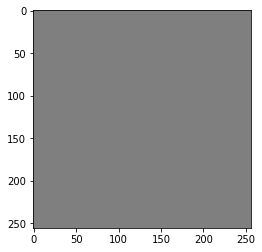

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

generated_image = desnormalize_image(generated_image[0]).numpy()
plt.imshow(generated_image.astype("uint8"))

#plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#plt.imshow(generated_image[0, :, :, 0])
#plt.imshow(generated_image[0])

## The Discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[img_height, img_width, 3])) #mgm input_shape=[28, 28, 1]
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generated_image
(256, 256, 3)
<class 'numpy.ndarray'>
(1, 256, 256, 3)
tf.Tensor([[2.5210276]], shape=(1, 1), dtype=float32)


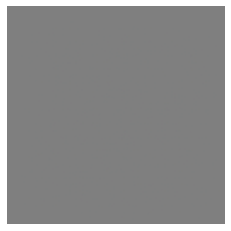

In [ ]:
discriminator = make_discriminator_model()

print("generated_image")
print(generated_image.shape)
#plt.imshow(generated_image[0]*256)
#plt.show()
#plot_image((generated_image[0]*256).numpy().astype("uint8"))

plot_image(generated_image.astype("uint8"))
print(type(generated_image))
generated_image = tf.reshape(generated_image, [1,img_height,img_width,3])
print(generated_image.shape)
decision = discriminator(generated_image)
print (decision)

(256, 256, 3)


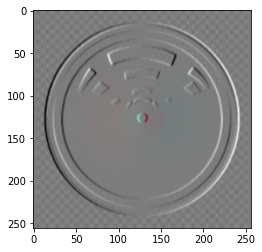

tf.Tensor([[2.827032]], shape=(1, 1), dtype=float32)


In [ ]:
for images, labels in train_ds_2001.take(1):
  generated_image =  images[0]
  print(generated_image.shape)
  plt.imshow(generated_image.numpy().astype("uint8"))
  plt.show()  
  generated_image = tf.reshape(generated_image, [1,img_height,img_width,3])
  decision = discriminator(generated_image)
  print(decision)

# Define the loss and optimizers

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define the training loop

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)


    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
                        

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


### Generate and save images

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      prediction = desnormalize_image(predictions[i])
      # prediction = rgb2gray(prediction.numpy().astype("uint8"))
      prediction = prediction.numpy().astype("uint8")
      plt.imshow(prediction, cmap="gray")

      #plt.imshow(prediction.numpy().astype("uint8"))
      plt.axis('off')

  path = IMAGES_OUT_TRAINING+'image_at_epoch_{:04d}.png'.format(epoch)
  plt.savefig(path)
  plt.show()

### Train the model

In [ ]:
from tensorflow.keras import layers

#normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.9804199517941943 0.9883845310585172
(256, 256, 3)


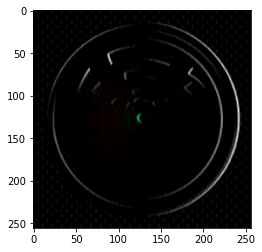

In [ ]:
#normalized_ds = train_ds_2001.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))

image_batch = next(iter(train_ds_2001_images_tf_batch))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 
print(first_image.shape)
plt.imshow(first_image, cmap="gray")
plt.show()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

#normalized_ds = train_ds_2001_images_tf.cache().prefetch(buffer_size=AUTOTUNE)
normalized_ds = train_ds_2001_images_tf_batch.prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds_2001_images_tf

<TensorSliceDataset shapes: (256, 256, 3), types: tf.float64>

In [ ]:
#train(train_ds_2001_images_tf, EPOCHS)
train(normalized_ds, EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

(1, 100)


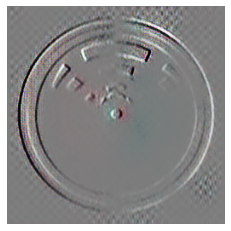

In [ ]:
seed = tf.random.normal([1, noise_dim])
print(seed.shape)
predictions = generator(seed, training=False)

prediction = desnormalize_image(predictions[0])
prediction = prediction.numpy().astype("uint8")
plt.imshow(prediction, cmap="gray")
plt.axis('off')

#plt.savefig('hal_generated_gray.png')
plt.show()
path = IMAGES_GENERATED+"hal_generated_gray.png"
tf.keras.preprocessing.image.save_img(
    path, prediction, data_format=None, file_format=None, scale=True
)
